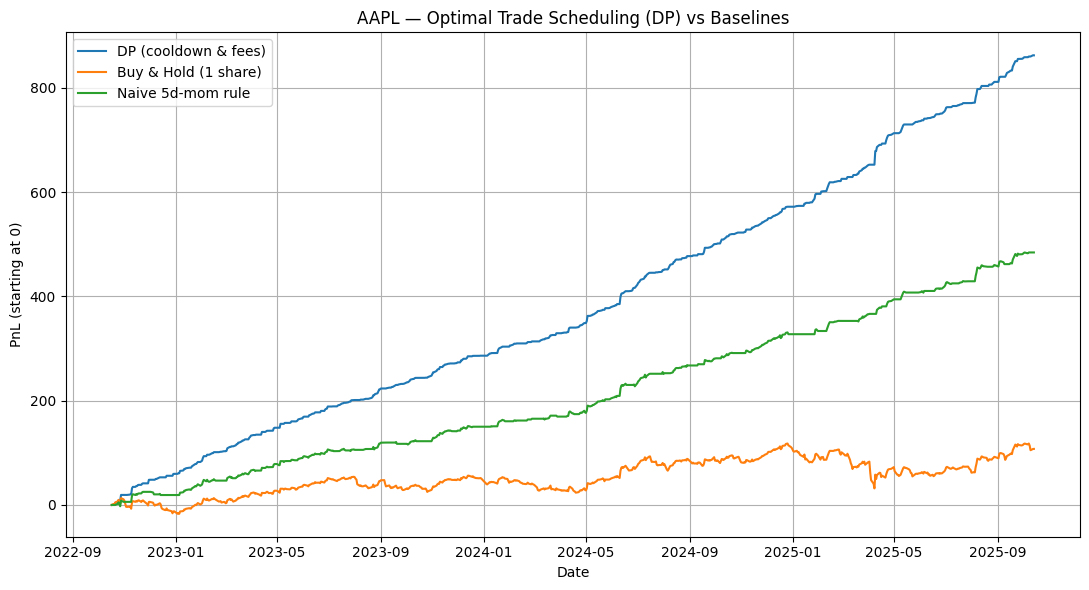

=== DP Policy Trades ===
action       date      price
   BUY 2022-10-20 141.161682
  SELL 2022-10-25 149.972610
   BUY 2022-10-27 142.549820
  SELL 2022-10-28 153.319809
   BUY 2022-11-04 136.455551
  SELL 2022-11-08 137.559937
   BUY 2022-11-09 132.994339
  SELL 2022-11-11 147.618103
   BUY 2022-11-14 146.217880
  SELL 2022-11-15 147.953384
   BUY 2022-11-16 146.720764
  SELL 2022-11-18 149.185989
   BUY 2022-11-21 145.951614
  SELL 2022-11-23 148.969101
   BUY 2022-11-29 139.206757
  SELL 2022-12-01 146.247467
   BUY 2022-12-07 138.979935
  SELL 2022-12-08 140.666153
   BUY 2022-12-09 140.182999
  SELL 2022-12-13 143.446915

Total trades: 340  (round-trip ≈ 170)

=== Annualized (rough demo metrics) ===
DP:   mu=0.209, vol=0.023, Sharpe≈9.07
B&H:  mu=0.036, vol=0.049, Sharpe≈0.72
Rule: mu=0.133, vol=0.027, Sharpe≈4.93


In [2]:
# Step 16 — DP: Optimal Trade Scheduling with Cooldown & Fees (fixed scalars)
import numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt
from dataclasses import dataclass

TICKER = "AAPL"
PERIOD = "3y"
INTERVAL = "1d"
COOLDOWN_DAYS = 1
FEE_PER_TRADE = 0.001   # 10 bps on sells
SLIPPAGE_PCT = 0.0

# --- Data ---
px = yf.download(TICKER, period=PERIOD, interval=INTERVAL, auto_adjust=True, progress=False)["Close"].dropna()
dates = px.index.to_list()
prices = px.astype(float).to_numpy().reshape(-1)  # 1-D float array
n = len(prices)
if n < 10:
    raise SystemExit("Not enough data.")

# --- DP arrays (float dtype) ---
hold = np.full(n, -np.inf, dtype=float)
free = np.full(n, -np.inf, dtype=float)
cool = np.full((COOLDOWN_DAYS+1, n), -np.inf, dtype=float)  # cool[k,t], k=1..c; cool[0] unused

# Init day 0
buy_cost0 = float(prices[0]) * (1.0 + SLIPPAGE_PCT)
hold[0] = float(-buy_cost0)   # either buy at t=0...
free[0] = 0.0                 # ...or stay flat
for k in range(1, COOLDOWN_DAYS+1):
    cool[k,0] = -np.inf

@dataclass
class Prev:
    state: str
    idx: int
    extra: int | None = None

prev_ptr = {("hold",0): ("free",-1,None)}
prev_ptr[("free",0)] = ("free",-1,None)
for k in range(1, COOLDOWN_DAYS+1):
    prev_ptr[(f"cool{k}",0)] = (f"cool{k}",-1,None)

# --- DP forward ---
for t in range(1, n):
    price = float(prices[t])
    buy_cost  = float(price * (1.0 + SLIPPAGE_PCT))
    sell_recv = float(price * (1.0 - FEE_PER_TRADE - SLIPPAGE_PCT))

    # HOLD: stay or buy from FREE
    stay_hold = hold[t-1]
    buy = free[t-1] - buy_cost
    if buy > stay_hold:
        hold[t] = float(buy)
        prev_ptr[("hold",t)] = ("free", t-1, None)
    else:
        hold[t] = float(stay_hold)
        prev_ptr[("hold",t)] = ("hold", t-1, None)

    # SELL -> enter max cooldown
    new_cool_val = float(hold[t-1] + sell_recv)
    # Default “stay” path for the top cooldown bucket
    stay_top = cool[COOLDOWN_DAYS, t-1]
    if new_cool_val > stay_top:
        cool[COOLDOWN_DAYS, t] = new_cool_val
        prev_ptr[(f"cool{COOLDOWN_DAYS}",t)] = ("hold", t-1, None)
    else:
        cool[COOLDOWN_DAYS, t] = float(stay_top)
        prev_ptr[(f"cool{COOLDOWN_DAYS}",t)] = (f"cool{COOLDOWN_DAYS}", t-1, None)

    # Cooldown decay
    for k in range(COOLDOWN_DAYS-1, 0, -1):
        stay = cool[k, t-1]
        from_above = cool[k+1, t]
        if from_above >= stay:
            cool[k, t] = float(from_above)
            prev_ptr[(f"cool{k}",t)] = (f"cool{k+1}", t, None)
        else:
            cool[k, t] = float(stay)
            prev_ptr[(f"cool{k}",t)] = (f"cool{k}", t-1, None)

    # FREE: either stay free, or cooldown finishes (k=1 -> FREE)
    stay_free   = free[t-1]
    from_cool1  = cool[1, t] if COOLDOWN_DAYS >= 1 else -np.inf
    if from_cool1 >= stay_free:
        free[t] = float(from_cool1)
        prev_ptr[("free",t)] = ("cool1", t, None)
    else:
        free[t] = float(stay_free)
        prev_ptr[("free",t)] = ("free", t-1, None)

# --- Pick best terminal state ---
cands = [("free", free[n-1])] + [(f"cool{k}", cool[k,n-1]) for k in range(1, COOLDOWN_DAYS+1)]
# optionally allow closing a hold at last price:
# cands.append(("hold_closed", hold[n-1] + prices[-1]*(1 - FEE_PER_TRADE - SLIPPAGE_PCT)))
best_state, best_val = max(cands, key=lambda x: x[1])

# --- Reconstruct trades ---
actions = []
state, t = best_state, n-1
while t >= 0 and (state, t) in prev_ptr:
    prev_state, prev_t, _ = prev_ptr[(state, t)]
    if prev_t >= 0:
        if prev_state == "free" and state == "hold":
            actions.append(("BUY", dates[t], float(prices[t])))
        elif prev_state == "hold" and state.startswith("cool"):
            actions.append(("SELL", dates[t], float(prices[t])))
    state, t = prev_state, prev_t
actions.reverse()

# Compact trade list (BUY/SELL pairs)
trades = []
position = 0
for a, d, p in actions:
    if a == "BUY" and position == 0:
        trades.append({"action":"BUY","date":d.date(),"price":float(p)})
        position = 1
    elif a == "SELL" and position == 1:
        trades.append({"action":"SELL","date":d.date(),"price":float(p)})
        position = 0
trades_df = pd.DataFrame(trades)

# --- Equity curves ---
cash = 0.0
pos = 0
equity = []
for i in range(n):
    price = float(prices[i])
    day = dates[i].date()
    # execute trades at today's close
    todays = [x for x in trades if x["date"] == day]
    for tr in todays:
        if tr["action"] == "BUY" and pos == 0:
            pos = 1
            cash -= float(price * (1.0 + SLIPPAGE_PCT))
        elif tr["action"] == "SELL" and pos == 1:
            pos = 0
            cash += float(price * (1.0 - FEE_PER_TRADE - SLIPPAGE_PCT))
    eq = float(cash + (price if pos==1 else 0.0))
    equity.append(eq)

equity = np.asarray(equity, dtype=float)
equity = equity - equity[0]

bh_equity = prices - prices[0]
ret5 = pd.Series(prices).pct_change(5).fillna(0.0).to_numpy()
pos_rule = (ret5 > 0).astype(int)
rule_equity = np.cumsum(np.diff(prices, prepend=prices[0]) * pos_rule)

# --- Plots ---
plt.figure(figsize=(11,6))
plt.plot(dates, equity, label="DP (cooldown & fees)")
plt.plot(dates, bh_equity, label="Buy & Hold (1 share)")
plt.plot(dates, rule_equity, label="Naive 5d-mom rule")
plt.title(f"{TICKER} — Optimal Trade Scheduling (DP) vs Baselines")
plt.xlabel("Date"); plt.ylabel("PnL (starting at 0)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# --- Stats ---
def ann_stats(pnl_series):
    eq = pnl_series + 1_000.0
    rets = pd.Series(eq).pct_change().fillna(0.0)
    mu = float(rets.mean()*252)
    sig = float(rets.std()*np.sqrt(252))
    sharpe = float(mu/sig) if sig>0 else np.nan
    return mu, sig, sharpe

mu_dp, sig_dp, sh_dp = ann_stats(equity)
mu_bh, sig_bh, sh_bh = ann_stats(bh_equity)
mu_rl, sig_rl, sh_rl = ann_stats(rule_equity)

print("=== DP Policy Trades ===")
print(trades_df.head(20).to_string(index=False))
print(f"\nTotal trades: {len(trades_df)}  (round-trip ≈ {len(trades_df)//2})")

print("\n=== Annualized (rough demo metrics) ===")
print(f"DP:   mu={mu_dp:.3f}, vol={sig_dp:.3f}, Sharpe≈{sh_dp:.2f}")
print(f"B&H:  mu={mu_bh:.3f}, vol={sig_bh:.3f}, Sharpe≈{sh_bh:.2f}")
print(f"Rule: mu={mu_rl:.3f}, vol={sig_rl:.3f}, Sharpe≈{sh_rl:.2f}")
